# Special case 2-view geometry estimating homography transformation

In case you need to project points from one plane to another, it's possible to do by applying a homography matrix. This matrix allows you to project a point from one plane to another if you know the corresponding transformation for the planes. OpenCV has a functionality to find the homography matrix, and this recipe shows you how to use and apply it.

To be able to project a point from one plane to another, first you need to compute the homography matrix. It can be performed with `cv2.findHomography`. This function accepts the following arguments:

* A set of points from the source (first) plane 
* A set of points from the destination (second) plane 
* A method to find homography 
* A threshold to filter outliers 
* An output mask for outliers 
* The maximum number of iterations 
* Confidence

All arguments except the first two use the default values. The method argument describes which algorithm should be used to compute the homography. By default, all points are used, but if your data tends to contain a considerable number of outliers (points with a high portion of noise or mischosen ones), it's better to use one of these methods: `cv2.RANSAC`, `cv2.LMEDS`, or `cv2.RHO`. These methods correctly filter out outliers. The threshold to filter outliers is the distance in pixels, which determines the type of the point: inlier or outlier. The mask is an object to store the values for inlier/outlier classes for each points. The maximum number of iterations and confidence determine the correctness of the solution. `cv2.findHomography` returns the found homography matrix and mask values for the points. It's also worth mentioning that you need to check that the resulting matrix is not an empty object, because a solution cannot be found for all sets of points.

After you find the homography matrix, you can apply it to the image projections by passing it to `cv2.warpPerspective`. It's also possible to project the points by multiplying them by the homography matrix (see the code).

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    #plt.gca().invert_yaxis() plt.gca().invert_xaxis()
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


------  data/pinhole_calib/img_00.png    Shape(480, 640, 3) img_0: uint8
[[44 44 44] [42 42 42] [42 42 42] [43 43 43] [41 45 49] [41 45 49] [43 47 48] ]
[[44 44 44] [44 44 44] [42 41 43] [43 42 45] [44 43 46] [44 43 46] [41 45 49] ]
------  data/pinhole_calib/img_10.png    Shape(480, 640, 3) img_1: uint8
[[46 44 44] [46 44 44] [46 46 39] [46 46 39] [44 45 36] [44 45 36] [48 47 38] ]
[[48 43 44] [48 43 44] [47 45 38] [48 46 39] [47 46 37] [45 43 34] [47 45 38] ]


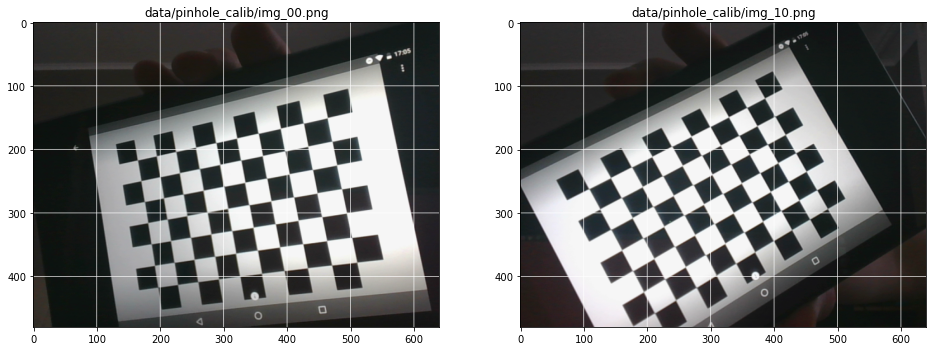

In [2]:
camera_matrix = np.load('data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('data/pinhole_calib/dist_coefs.npy')
img_0 = cv2.imread('data/pinhole_calib/img_00.png')
img_1 = cv2.imread('data/pinhole_calib/img_10.png')



#############################################################
print_image('data/pinhole_calib/img_00.png','img_0',img_0,0,2,0,7)
print_image('data/pinhole_calib/img_10.png','img_1',img_1,0,2,0,7)
plt_view_image(plt,[["data/pinhole_calib/img_00.png",  
                     draw_grid(np.copy(img_0),100,(255,255,255))[:,:,[2,1,0]]],
                    ["data/pinhole_calib/img_10.png", 
                     draw_grid(np.copy(img_1),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

------  data/pinhole_calib/img_00.png    Shape(480, 640, 3) img_0: uint8
[[44 44 44] [42 42 42] [42 42 42] [43 43 43] [41 45 49] [41 45 49] [43 47 48] ]
[[44 44 44] [44 44 44] [42 41 43] [43 42 45] [44 43 46] [44 43 46] [41 45 49] ]
------  data/pinhole_calib/img_10.png    Shape(480, 640, 3) img_1: uint8
[[46 44 44] [46 44 44] [46 46 39] [46 46 39] [44 45 36] [44 45 36] [48 47 38] ]
[[48 43 44] [48 43 44] [47 45 38] [48 46 39] [47 46 37] [45 43 34] [47 45 38] ]
------  img_0_undistort----------    Shape(480, 640, 3) img_0_undistort: uint8
[[43 43 43] [42 42 42] [42 42 43] [43 43 44] [41 45 49] [38 42 46] [36 39 41] ]
[[44 44 44] [43 43 44] [42 42 43] [43 42 45] [44 43 46] [44 43 46] [42 45 48] ]
------  img_1_undistort----------    Shape(480, 640, 3) img_1_undistort: uint8
[[47 44 44] [46 45 42] [46 46 39] [46 46 39] [44 45 36] [41 42 34] [40 39 32] ]
[[48 42 45] [47 43 43] [47 45 39] [48 46 39] [47 46 37] [45 44 35] [47 45 37] ]


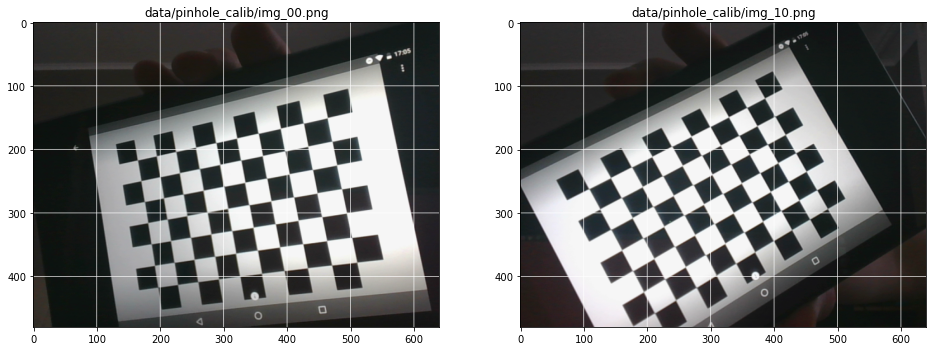

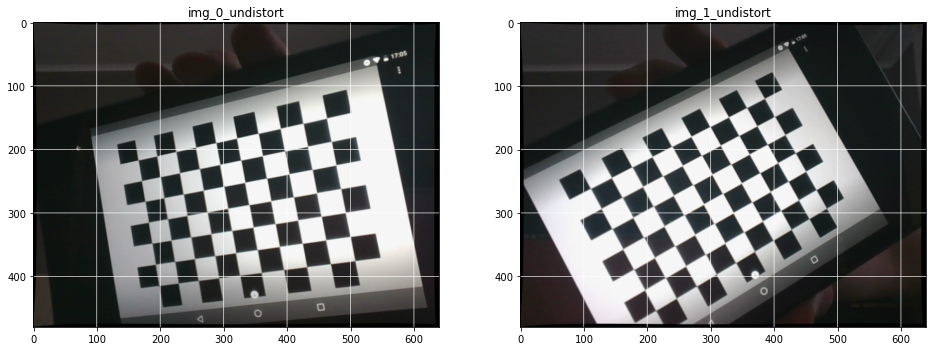

In [3]:
img_0_undistort = cv2.undistort(img_0, camera_matrix, dist_coefs)
img_1_undistort = cv2.undistort(img_1, camera_matrix, dist_coefs)


#############################################################
print_image('data/pinhole_calib/img_00.png','img_0',img_0,0,2,0,7)
print_image('data/pinhole_calib/img_10.png','img_1',img_1,0,2,0,7)
print_image('img_0_undistort','img_0_undistort',img_0_undistort,0,2,0,7)
print_image('img_1_undistort','img_1_undistort',img_1_undistort,0,2,0,7)

plt_view_image(plt,[["data/pinhole_calib/img_00.png",  
                     draw_grid(np.copy(img_0),100,(255,255,255))[:,:,[2,1,0]]],
                    ["data/pinhole_calib/img_10.png", 
                     draw_grid(np.copy(img_1),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["img_0_undistort",draw_grid(np.copy(img_0_undistort),100,(255,255,255))[:,:,[2,1,0]]],
                    ["img_1_undistort",draw_grid(np.copy(img_1_undistort),100,(255,255,255))[:,:,[2,1,0]]]],
               figsize=(16,8), axis='on', cmap='gray')

<ipython-input-4-27ea5b69972d>:12: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_0_un, tuple(c[0]), 5, (0, 255, 0), 5)
<ipython-input-4-27ea5b69972d>:14: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_1_un, tuple(c[0]), 5, (255, 0, 0), 5)
No handles with labels found to put in legend.


True
------  corners_0----------------    Shape(70, 1, 2) corners_0: float32
[[164.6092  216.80879] ]
[[196.40352 209.99544] ]
[[224.08304 203.48598] ]
[[257.52408 196.19748] ]
[[288.4632  189.91542] ]
[[322.16205 182.31001] ]
[[355.51205 175.40602] ]
True
------  corners_1----------------    Shape(70, 1, 2) corners_1: float32
[[111.289314 262.12796 ] ]
[[144.46918 244.94386] ]
[[176.66023 228.31508] ]
[[208.46176 212.01628] ]
[[239.29413 195.7612 ] ]
[[269.93347 180.12181] ]
[[299.68207 164.69058] ]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


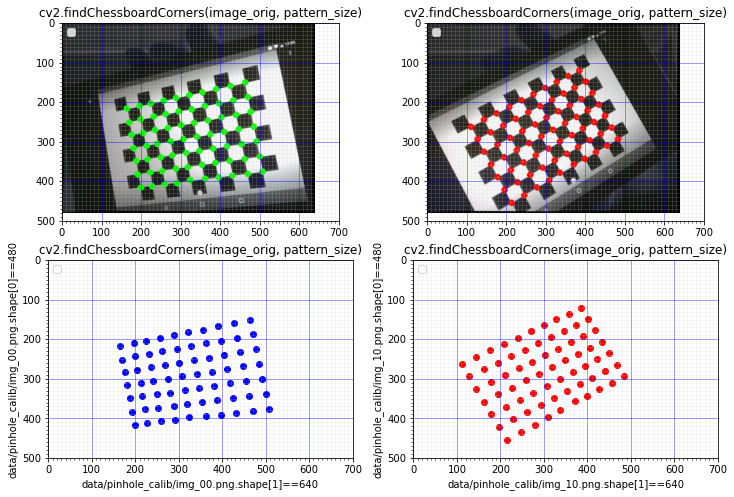

In [4]:
pattern_size = (10, 7)
res_0, corners_0 = cv2.findChessboardCorners(img_0_undistort, pattern_size)
res_1, corners_1 = cv2.findChessboardCorners(img_1_undistort, pattern_size)



#############################################################
img_0_un = np.copy(img_0_undistort)
img_1_un = np.copy(img_1_undistort)

for c in corners_0:
    cv2.circle(img_0_un, tuple(c[0]), 5, (0, 255, 0), 5)
for c in corners_1:
    cv2.circle(img_1_un, tuple(c[0]), 5, (255, 0, 0), 5)
    
print(res_0)
print_image('corners_0','corners_0',corners_0,0,7,0,7)
print(res_1)
print_image('corners_1','corners_1',corners_1,0,7,0,7)


plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.imshow(img_0_un,cmap='gray' )
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.imshow(img_1_un,cmap='gray' )
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.subplot(2,2,3)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.scatter(corners_0[:,:,0], corners_0[:,:,1], color='blue')
plt.xlabel('data/pinhole_calib/img_00.png.shape[1]=={}'.format(img_0_undistort.shape[1]));
plt.ylabel('data/pinhole_calib/img_00.png.shape[0]=={}'.format(img_0_undistort.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.subplot(2,2,4)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.scatter(corners_1[:,:,0], corners_1[:,:,1], color='red')
plt.xlabel('data/pinhole_calib/img_10.png.shape[1]=={}'.format(img_1_undistort.shape[1]));
plt.ylabel('data/pinhole_calib/img_10.png.shape[0]=={}'.format(img_1_undistort.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.show()

<ipython-input-5-7a04accab96b>:14: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_0_Pix, tuple(c[0]), 5, (0, 255, 0), 5)
<ipython-input-5-7a04accab96b>:16: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(img_1_Pix, tuple(c[0]), 5, (255, 0, 0), 5)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


------  corners_0_Pix------------    Shape(70, 1, 2) corners_0_Pix: float32
[[165.79814 217.4091 ] ]
[[195.37196 210.87863] ]
[[225.43216 204.22684] ]
[[256.587   197.30452] ]
[[288.4746  190.21843] ]
[[321.37976 182.829  ] ]
[[355.19275 175.3648 ] ]
------  corners_1_Pix------------    Shape(70, 1, 2) corners_1_Pix: float32
[[111.256775 262.0947  ] ]
[[144.43716 244.99954] ]
[[176.7559  228.33192] ]
[[208.51627 211.88965] ]
[[239.4193  195.82877] ]
[[269.8699  180.18083] ]
[[299.6163  164.73587] ]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


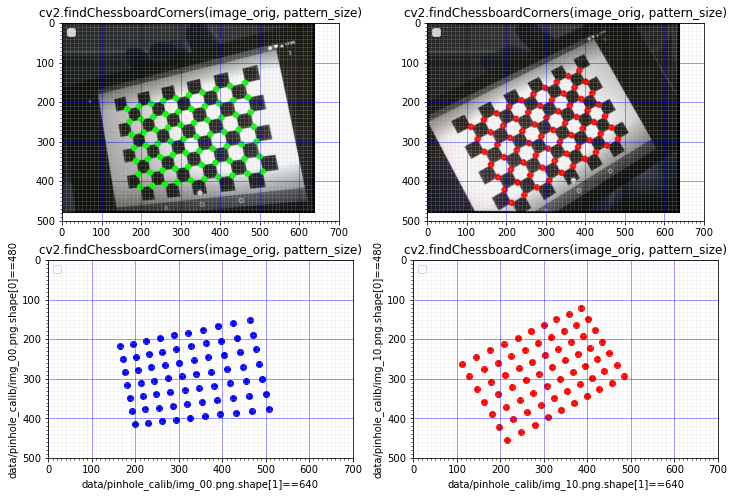

In [5]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
corners_0_Pix = cv2.cornerSubPix(cv2.cvtColor(img_0_undistort, cv2.COLOR_BGR2GRAY),
                                 corners_0,(10,10),(-1,-1),criteria)
corners_1_Pix = cv2.cornerSubPix(cv2.cvtColor(img_1_undistort, cv2.COLOR_BGR2GRAY),
                                 corners_1,(10,10),(-1,-1),criteria)



#############################################################
img_0_Pix = np.copy(img_0_undistort)
img_1_Pix = np.copy(img_1_undistort)

for c in corners_0_Pix:
    cv2.circle(img_0_Pix, tuple(c[0]), 5, (0, 255, 0), 5)
for c in corners_1_Pix:
    cv2.circle(img_1_Pix, tuple(c[0]), 5, (255, 0, 0), 5)

print_image('corners_0_Pix','corners_0_Pix',corners_0_Pix,0,7,0,7)
print_image('corners_1_Pix','corners_1_Pix',corners_1_Pix,0,7,0,7)


plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.imshow(img_0_Pix,cmap='gray' )
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.imshow(img_1_Pix,cmap='gray' )
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.subplot(2,2,3)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.scatter(corners_0_Pix[:,:,0], corners_0_Pix[:,:,1], color='blue')
plt.xlabel('data/pinhole_calib/img_00.png.shape[1]=={}'.format(img_0_undistort.shape[1]));
plt.ylabel('data/pinhole_calib/img_00.png.shape[0]=={}'.format(img_0_undistort.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.subplot(2,2,4)
plt_view_grid(plt, 'on',(0,700,0,500),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()
plt.scatter(corners_1_Pix[:,:,0], corners_1_Pix[:,:,1], color='red')
plt.xlabel('data/pinhole_calib/img_10.png.shape[1]=={}'.format(img_1_undistort.shape[1]));
plt.ylabel('data/pinhole_calib/img_10.png.shape[0]=={}'.format(img_1_undistort.shape[0]))
plt.title("cv2.findChessboardCorners(image_orig, pattern_size)");
plt.legend(loc='upper left')

plt.show()

In [6]:
H, mask = cv2.findHomography(corners_0, corners_1)



######################################################
print(H)
print_image('mask','mask',mask,0,7,0,7)

[[ 1.47560231e+00  3.42657587e-01 -1.94333950e+02]
 [-1.71148404e-01  1.13004934e+00  7.69585798e+01]
 [ 9.12956249e-04 -1.32133106e-04  1.00000000e+00]]
------  mask---------------------    Shape(70, 1) mask: uint8
[ 1 ]
[ 1 ]
[ 1 ]
[ 1 ]
[ 1 ]
[ 1 ]
[ 1 ]


<ipython-input-7-4cca8f2944d7>:6: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img_0_mean = cv2.circle(img_0_undistort, tuple(center_0[:2]), 10, (0, 255, 0), 3)
<ipython-input-7-4cca8f2944d7>:7: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img_1_mean = cv2.circle(img_1_undistort, tuple(center_1[:2]), 10, (0, 0, 255), 3)


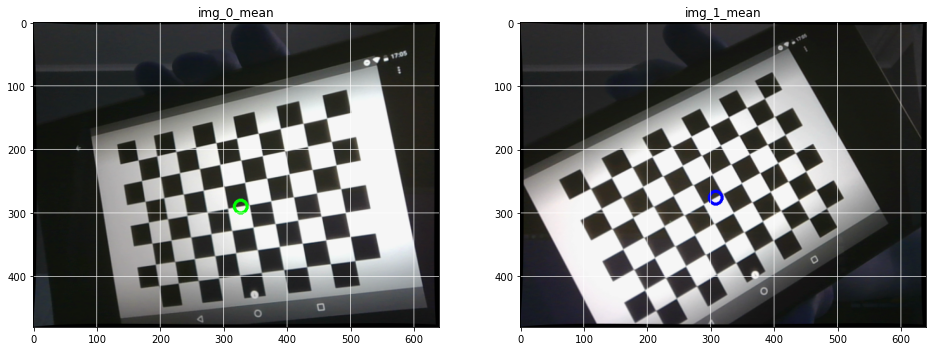

In [7]:
center_0 = np.mean(corners_0.squeeze(), 0)
center_0 = np.r_[center_0, 1]
center_1 = H @ center_0
center_1 = (center_1 / center_1[2]).astype(np.float32)

img_0_mean = cv2.circle(img_0_undistort, tuple(center_0[:2]), 10, (0, 255, 0), 3)
img_1_mean = cv2.circle(img_1_undistort, tuple(center_1[:2]), 10, (0, 0, 255), 3)



#############################################################
plt_view_image(plt,[["img_0_mean", draw_grid(np.copy(img_0_mean),100,(255,255,255))],
                    ["img_1_mean", draw_grid(np.copy(img_1_mean),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

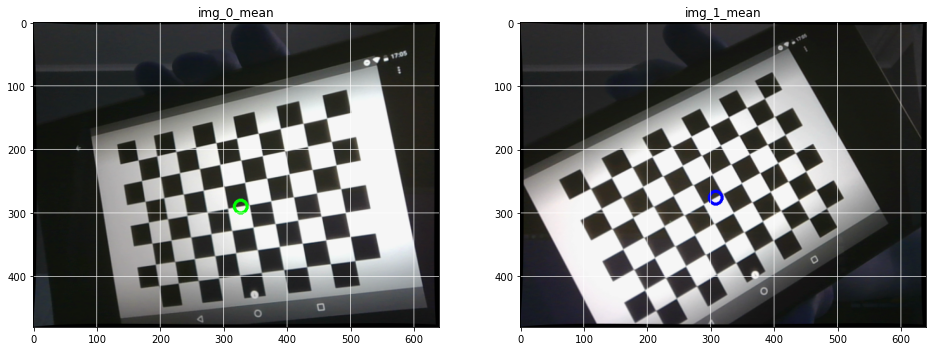

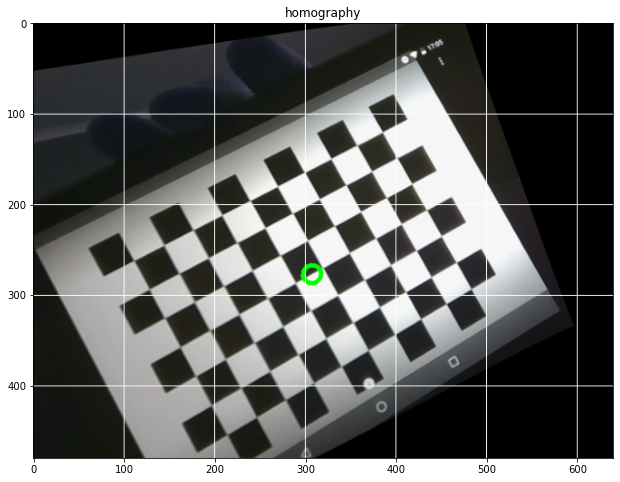

In [8]:
img_0_warped = cv2.warpPerspective(img_0_undistort, H, img_0.shape[:2][::-1])



#############################################################
plt_view_image(plt,[["img_0_mean", draw_grid(np.copy(img_0_mean),100,(255,255,255))],
                    ["img_1_mean", draw_grid(np.copy(img_1_mean),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["homography", draw_grid(np.copy(img_0_warped),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')